In [214]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *

In [220]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# 1 - Load data sets 

In [221]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')

nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)
cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)
cps['treat'] == 0 # created treated column
#load non experimental data (psid)
psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)
# reset indexes
nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# Exploratory Analysis

### Plotting functions

In [222]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [223]:
import matplotlib.gridspec as gridspec

class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [224]:
nsw[nsw['treat']==1].describe()
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [225]:
nswre74[nswre74['treat']==1].describe()
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


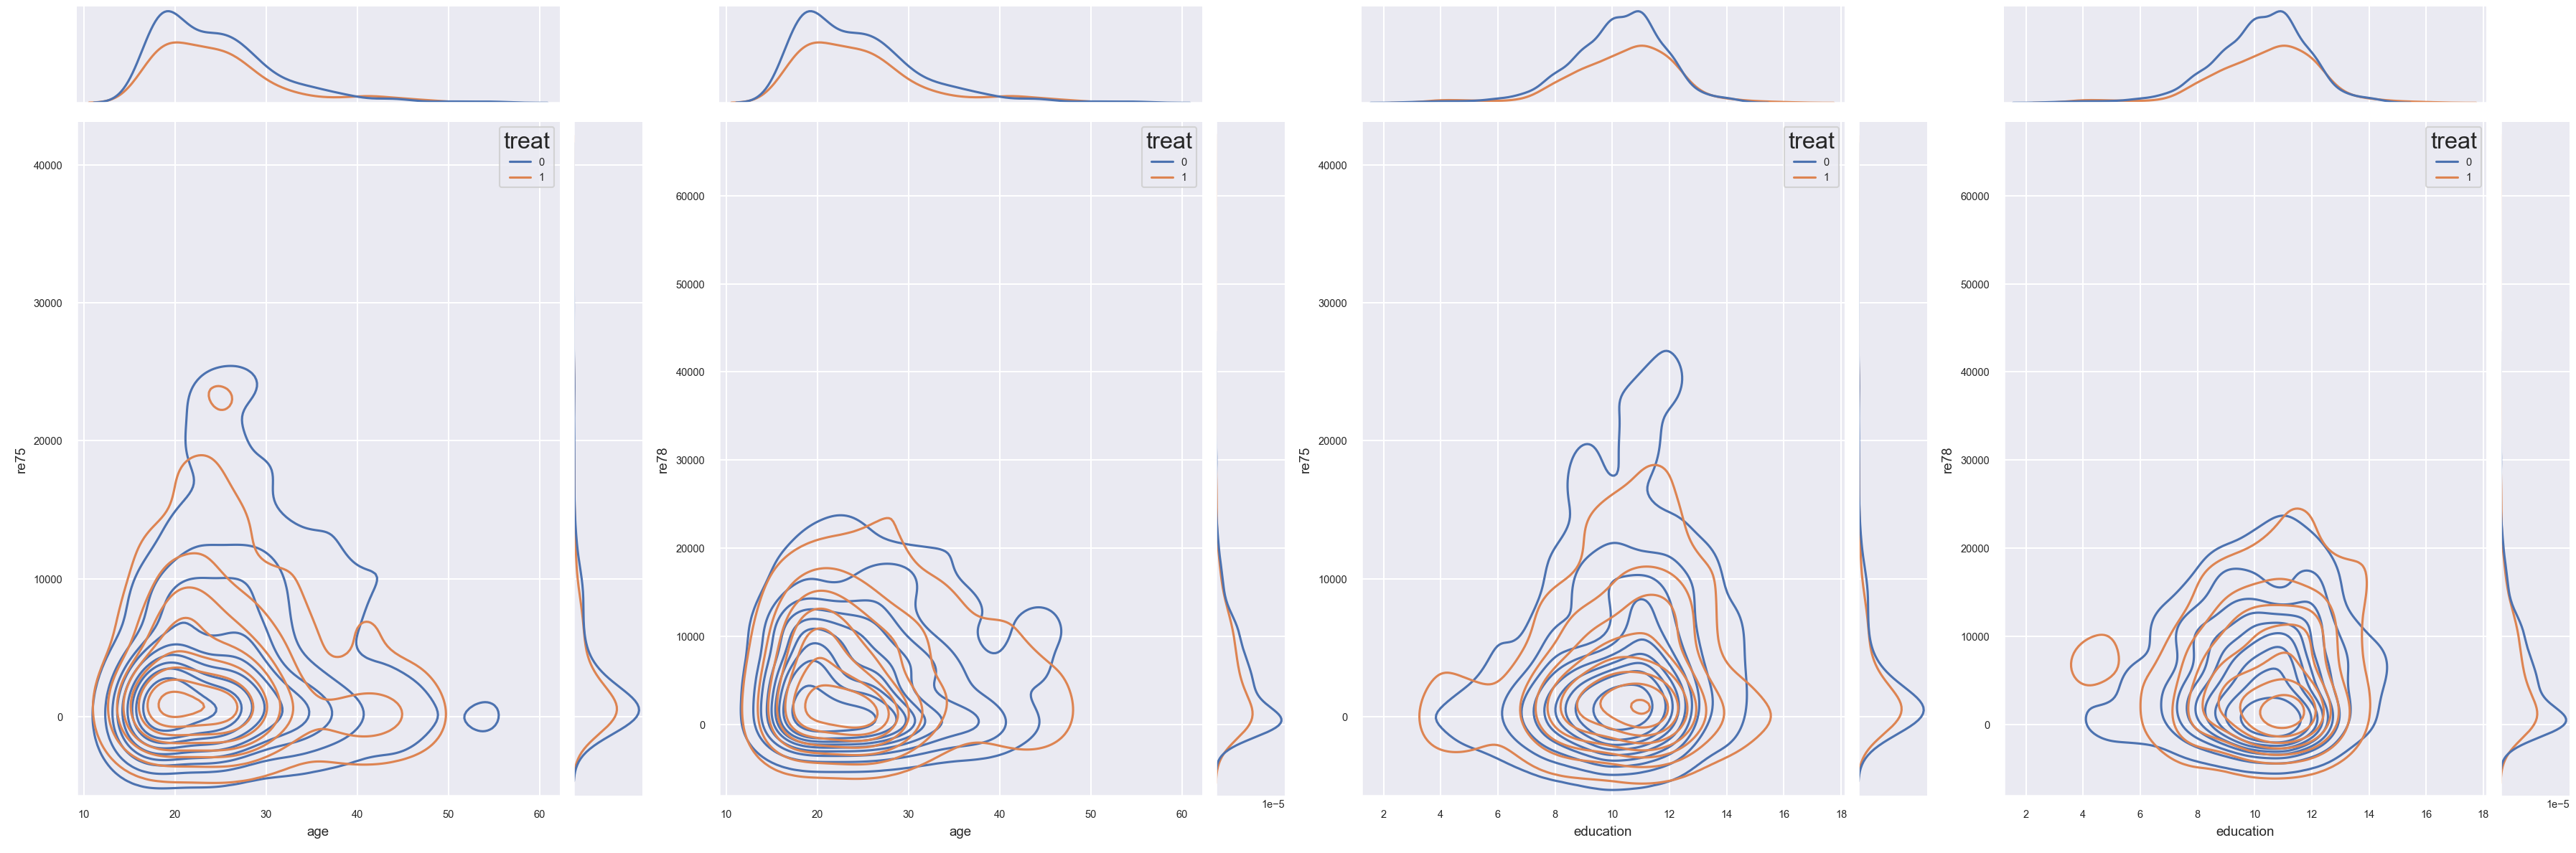

In [226]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


# QQ plots 
# Lalonde
plot_data(nsw,'age',"age")
plot_data(nsw,'education',"education")
plot_data(nsw,'re75',"re75")
plot_data(nsw,'re78',"re78")

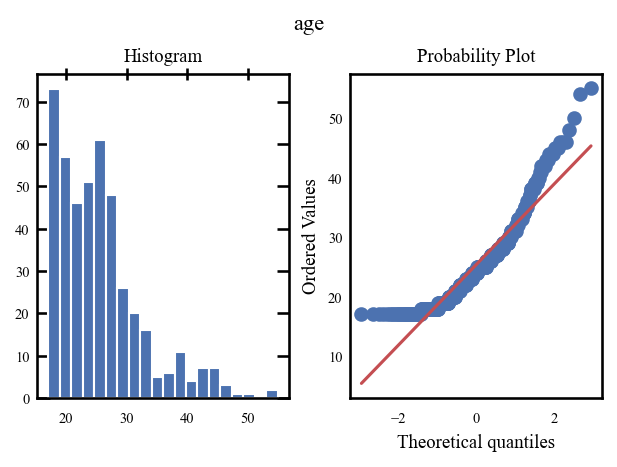

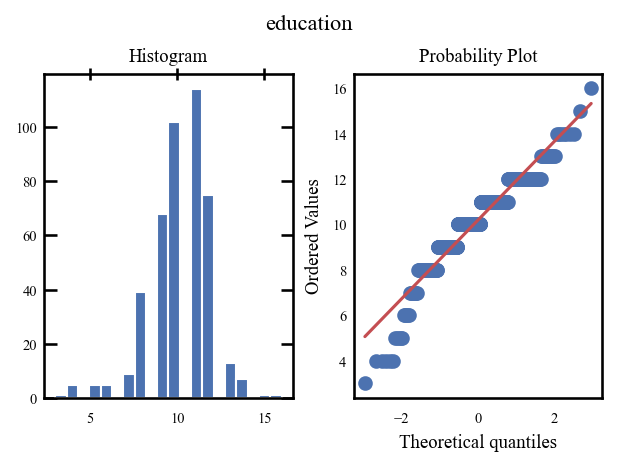

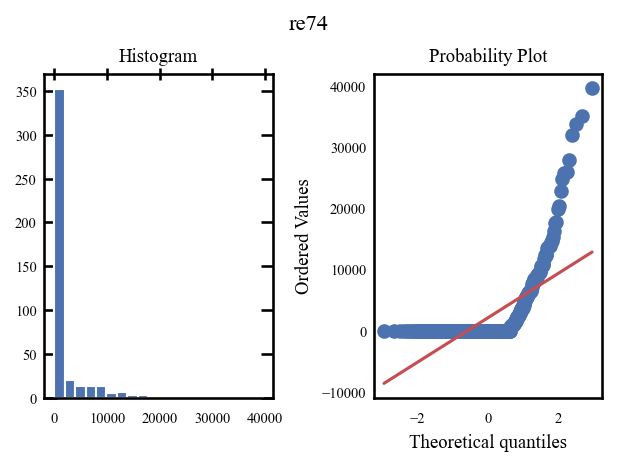

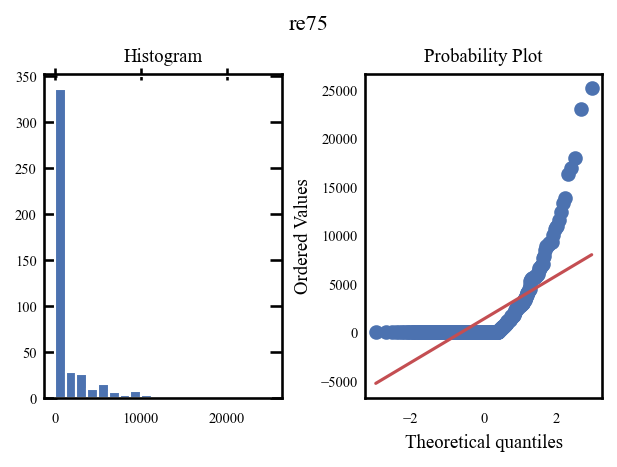

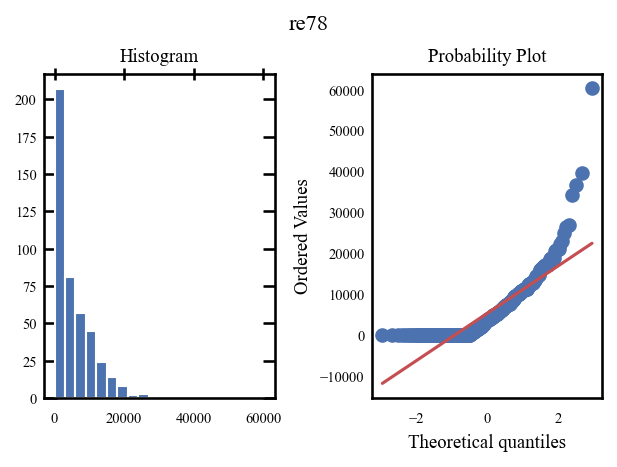

In [227]:
# QQ plots 
# Dehajia Wahba
plot_data(nswre74,'age',"age")
plot_data(nswre74,'education',"education")
plot_data(nswre74,'re74',"re74")
plot_data(nswre74,'re75',"re75")
plot_data(nswre74,'re78',"re78")

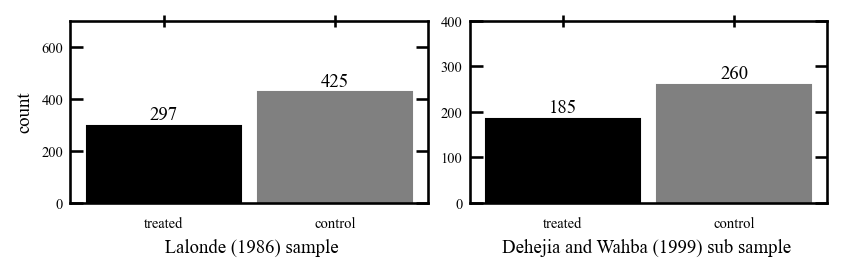

In [228]:
# Plot the balance of classes in the datasets 
#nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
#nsw.drop('data_id', axis=1, inplace=True)

#nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
#nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#nswre74 = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

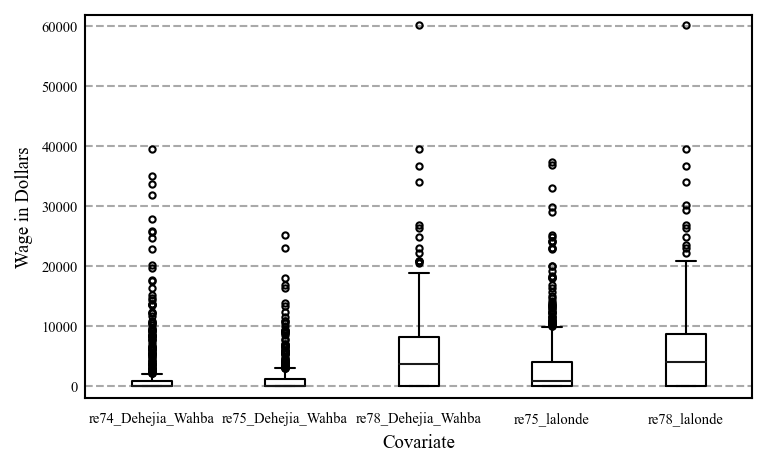

In [229]:
from tueplots import bundles 
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['re74_Dehejia_Wahba', 're75_Dehejia_Wahba','re78_Dehejia_Wahba','re75_lalonde','re78_lalonde'])

ax.set_xlabel('Covariate')
ax.set_ylabel('Wage in Dollars')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_wage_boxplots.png', bbox_inches='tight')
plt.show()

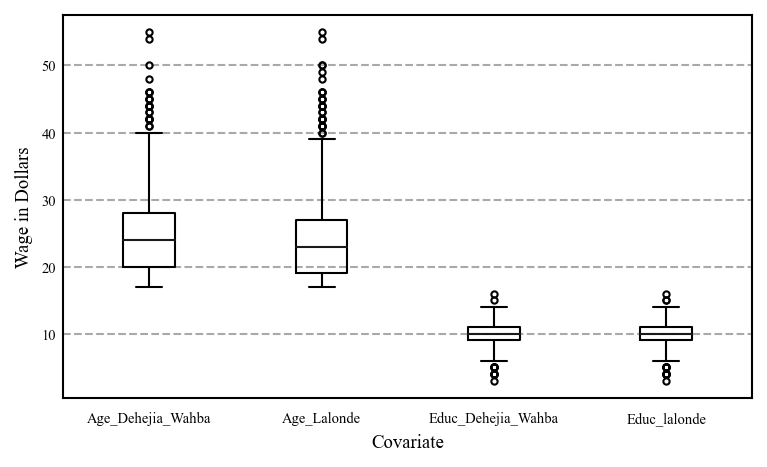

In [230]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

Age_dej = nswre74['age']
Educ_dej = nswre74['education']



ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age_Dehejia_Wahba', 'Age_Lalonde','Educ_Dehejia_Wahba','Educ_lalonde'])


ax.set_xlabel('Covariate')

ax.set_ylabel('Wage in Dollars')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

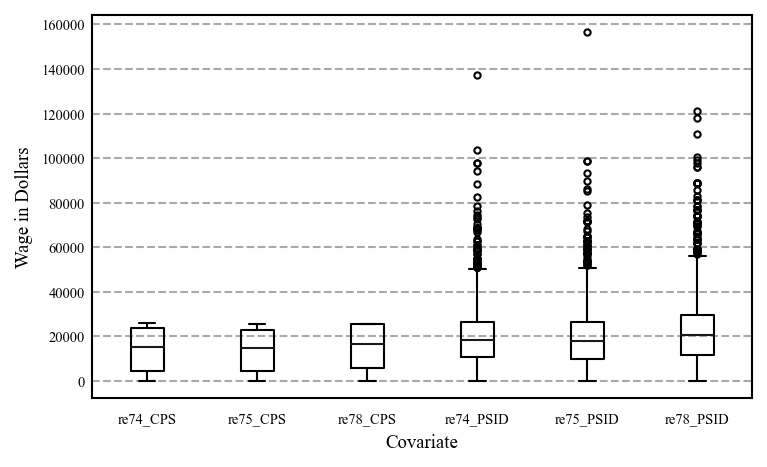

In [231]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps['re74']
wage75_cps = cps['re75']
wage78_cps = cps['re78']

wage74_psid = psid['re74']
wage75_psid = psid['re75']
wage78_psid = psid['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['re74_CPS', 're75_CPS','re78_CPS','re74_PSID','re75_PSID','re78_PSID'])

ax.set_xlabel('Covariate')
ax.set_ylabel('Wage in Dollars')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

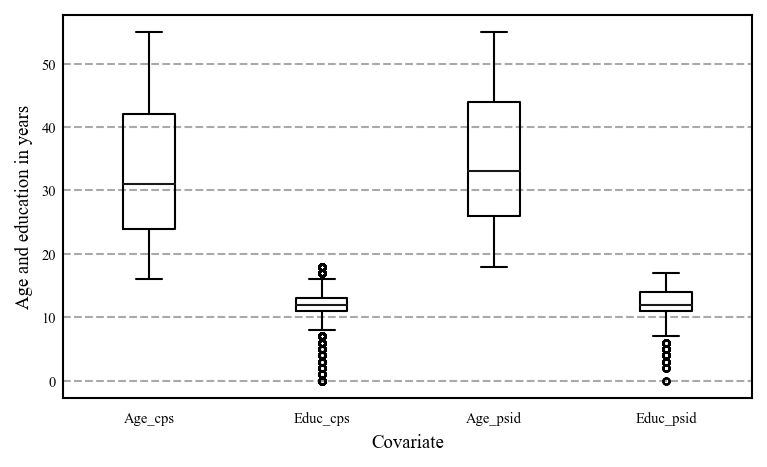

In [232]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps['age']
Educ_cps = cps['education']

Age_psid = psid['age']
Educ_psid = psid['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age_cps', 'Educ_cps','Age_psid','Educ_psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [233]:
# Drop outliers 
cols = ['re75','re78','age','education'] 
cols2 = ['re74','re75','re78','age','education'] 

lower_bound = 0.5
upper_bound = 0.95

Q1_1 = nsw[cols].quantile(lower_bound)
Q3_1 = nsw[cols].quantile(upper_bound)
IQR_1 = Q3_1 - Q1_1

Q1_2 = nswre74[cols2].quantile(lower_bound)
Q3_2 = nswre74[cols2].quantile(upper_bound)
IQR_2 = Q3_2 - Q1_2

Q1_3 = cps[cols2].quantile(lower_bound)
Q3_3 = cps[cols2].quantile(upper_bound)
IQR_3 = Q3_3 - Q1_3

Q1_4 = psid[cols2].quantile(lower_bound)
Q3_4 = psid[cols2].quantile(upper_bound)
IQR_4 = Q3_4 - Q1_4

nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

cps1 = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
psid1 = psid[~((psid[cols2] < (Q1_4 - IQR_4)) |(psid[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

# account for integer overflow - change features we manipulate to 64bit type integer  

nsw['re75'] = nsw['re75'].astype(int)
nsw['re78'] = nsw['re78'].astype(int)
nsw['age'] = nsw['age'].astype(int)
nsw['education'] = nsw['education'].astype(int)

nswre74['re74'] = nswre74['re74'].astype(int)
nswre74['re75'] = nswre74['re75'].astype(int)
nswre74['re78'] = nswre74['re78'].astype(int)
nswre74['age'] = nswre74['age'].astype(int)
nswre74['education'] = nswre74['education'].astype(int)

# Transformation of Lalonde original 
warnings.filterwarnings('ignore')

# Generate for unemployed (== 1 if unemployed , == 0 otherwise)
nsw['u75'] = (nsw['re75'] == 0).astype('int')

# Generate interaction terms 
nsw['educ_re75'] = nsw['education']*nsw['re75']
nsw['hisp_u75'] = nsw['hispanic']*nsw['u75']
nsw['black_u75'] = nsw['black']*nsw['u75']


# change 0 to 1 for log transform
nsw['re78'][nsw['re78'] == 0] = 1
nsw['re75'][nsw['re75'] == 0] = 1

nsw['ageboxcox'],parameters=stat.boxcox(nsw['age'])

# Age squared
nsw['agesq'] = nsw['age']*nsw['age']

# boxcox transforms of varibles 
nsw['re78boxcox'],parameters=stat.boxcox(nsw['re78'])
nsw['re75boxcox'],parameters=stat.boxcox(nsw['re75'])

# natural logarith of wages 
nsw['lnre78'] = np.log(nsw['re78'])
nsw['lnre75'] = np.log(nsw['re75'])

#square of wages 
nsw['re78sq'] = nsw['re78']*nsw['re78']
nsw['re75sq'] = nsw['re75']*nsw['re75']

nsw['educsq'] = nsw['education']*nsw['education']


# change back 
nsw['re78'][nsw['re78'] == 1] = 0
nsw['re75'][nsw['re75'] == 1] = 0


# Plot 
plot_data(nsw,'ageboxcox','age Boxcox')

plot_data(nsw,'lnre78','lnre78')
plot_data(nsw,'lnre75','lnre75')

plot_data(nsw,'re78sq','re78^2')
plot_data(nsw,'re75sq','re75^2')

plot_data(nsw,'re78boxcox','re78 Boxcox')
plot_data(nsw,'re75boxcox','re75 Boxcox')

plot_data(nsw,'educsq','education^2')



# Transformation of Dehejia Wahba subample
warnings.filterwarnings('ignore')

# Generate dummy variables 

nswre74['u74'] = (nswre74['re74'] == 0).astype('int')
nswre74['u75'] = (nswre74['re75'] == 0).astype('int')

# Generate interaction terms 
nswre74['educ_re74'] = nswre74['education']*nswre74['re74']
nswre74['educ_re75'] = nswre74['education']*nswre74['re75']

nswre74['hisp_u75'] = nswre74['hispanic']*nswre74['u75']
nswre74['hisp_u74'] = nswre74['hispanic']*nswre74['u74']

nswre74['black_u75'] = nswre74['black']*nswre74['u75']
nswre74['black_u74'] = nswre74['black']*nswre74['u74']

# Change zeroes to in wage as logs struggle
nswre74['re78'][nswre74['re78'] == 0] = 1
nswre74['re75'][nswre74['re75'] == 0] = 1
nswre74['re74'][nswre74['re74'] == 0] = 1


nswre74['ageboxcox'],parameters=stat.boxcox(nswre74['age'])

# Age squared
nswre74['agesq'] = nswre74['age']*nswre74['age']

# boxcox transforms of varibles 
nswre74['re78boxcox'],parameters=stat.boxcox(nswre74['re78'])
nswre74['re75boxcox'],parameters=stat.boxcox(nswre74['re75'])
nswre74['re74boxcox'],parameters=stat.boxcox(nswre74['re74'])

# natural logarith of wages 
nswre74['lnre78'] = np.log(nswre74['re78'])
nswre74['lnre75'] = np.log(nswre74['re75'])
nswre74['lnre74'] = np.log(nswre74['re74'])

#square of wages 
nswre74['re78sq'] = nswre74['re78']*nswre74['re78']
nswre74['re75sq'] = nswre74['re75']*nswre74['re75']
nswre74['re74sq'] = nswre74['re74']*nswre74['re74']

nswre74['educsq'] = nswre74['education']*nswre74['education']

# Plot 
plot_data(nswre74,'ageboxcox','age Boxcox')

plot_data(nswre74,'lnre78','lnre78')
plot_data(nswre74,'lnre75','lnre75')
plot_data(nswre74,'lnre74','lnre74')

plot_data(nswre74,'re78sq','re78^2')
plot_data(nswre74,'re75sq','re75^2')
plot_data(nswre74,'re74sq','re74^2')

plot_data(nswre74,'re78boxcox','re78 Boxcox')
plot_data(nswre74,'re75boxcox','re75 Boxcox')
plot_data(nswre74,'re74boxcox','re74 Boxcox')

plot_data(nswre74,'educsq','education^2')



# Transformation of CPS sample
cps1_feature_transformed = feature_tranform(cps1)

# Plot 
plot_data(cps1_feature_transformed,'ageboxcox','age Boxcox')

plot_data(cps1_feature_transformed,'lnre78','lnre78')
plot_data(cps1_feature_transformed,'lnre75','lnre75')
plot_data(cps1_feature_transformed,'lnre74','lnre74')

plot_data(cps1_feature_transformed,'re78sq','re78^2')
plot_data(cps1_feature_transformed,'re75sq','re75^2')
plot_data(cps1_feature_transformed,'re74sq','re74^2')

plot_data(cps1_feature_transformed,'re78boxcox','re78 Boxcox')
plot_data(cps1_feature_transformed,'re75boxcox','re75 Boxcox')
plot_data(cps1_feature_transformed,'re74boxcox','re74 Boxcox')

plot_data(cps1_feature_transformed,'educsq','education^2')

# Transformation of PSID sample
psid_feature_transformed = feature_tranform(psid1)

# Plot 
plot_data(psid_feature_transformed,'ageboxcox','age Boxcox')

plot_data(psid_feature_transformed,'lnre78','lnre78')
plot_data(psid_feature_transformed,'lnre75','lnre75')
plot_data(psid_feature_transformed,'lnre74','lnre74')

plot_data(psid_feature_transformed,'re78sq','re78^2')
plot_data(psid_feature_transformed,'re75sq','re75^2')
plot_data(psid_feature_transformed,'re74sq','re74^2')

plot_data(psid_feature_transformed,'re78boxcox','re78 Boxcox')
plot_data(psid_feature_transformed,'re75boxcox','re75 Boxcox')
plot_data(psid_feature_transformed,'re74boxcox','re74 Boxcox')

plot_data(psid_feature_transformed,'educsq','education^2')

### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (o mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

In [234]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer

    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 

    warnings.filterwarnings('ignore')

    if 're74' in dataset.columns: 
        dataset['re74'] = dataset['re74'].astype(int)  
        warnings.filterwarnings('ignore')
    else:
        pass

    # Keep a copy of education as numerical 
    dataset['education*'] = dataset['education']

    # Generate dummy variables 
    dataset['u75'] = (dataset['re75'] == 0).astype('int')
    # Generate interaction terms 
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    
    if 're74' in dataset.columns: 
        dataset['u74'] = (dataset['re74'] == 0).astype('int')
        dataset['educ_re74'] = dataset['education']*dataset['re74']
        dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
        dataset['black_u74'] = dataset['black']*dataset['u74']
    else:
        pass    

    # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 0] = 1
    dataset['re75'][dataset['re75'] == 0] = 1

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 0] = 1
    else:
        pass     
        
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    dataset['re78sq'] = dataset['re78']*dataset['re78']
    dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['educsq'] = dataset['education']*dataset['education']

    if 're74' in dataset.columns:
        dataset['re74sq'] = dataset['re74']*dataset['re74']
    else:
        pass      

    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    else:
        pass     
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['lnre74'] = np.log(dataset['re74'])
    else:
        pass 

    # encode education as binary indicator variable 
    dataset = pd.get_dummies(dataset, columns=["education"],drop_first=True)
    
    return dataset  

In [235]:
# Combine lalonde treated units with cps and psid groups
cps_no_re74 = cps.drop(['re74'],axis=1)   # drop wage in 1974 from cps comparison
psid_no_re74 = psid.drop(['re74'],axis=1) # drop wage in 1974 from psid comparison

# Create quasi-experimental datasets 
Quasi_NswCps_lalonde_ = pd.concat([nsw[nsw['treat']==1],cps_no_re74],ignore_index=True)
Quasi_NswPsid_lalonde_ = pd.concat([nsw[nsw['treat']==1],psid_no_re74],ignore_index=True)
Quasi_NswCps_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],cps],ignore_index=True)
Quasi_NswPsid_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],psid], ignore_index=True)

# Pass data sets through feature transformation function 
Quasi_NswCps_lalonde = feature_tranform(Quasi_NswCps_lalonde_)
Quasi_NswPsid_lalonde = feature_tranform(Quasi_NswPsid_lalonde_)
Quasi_NswCps_dehWab = feature_tranform(Quasi_NswCps_dehWab_)
Quasi_NswPsid_dehWab = feature_tranform(Quasi_NswPsid_dehWab_)

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
0,1.0,37,1.0,0.0,1.0,1.0,1,1,9930,11,...,0,0,0,1,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,1,1,3595,9,...,0,1,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,1,1,24909,12,...,0,0,0,0,1,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,1,1,7506,11,...,0,0,0,1,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,1,1,289,8,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652,0.0,47,0.0,0.0,1.0,1.0,44667,33837,38568,8,...,1,0,0,0,0,0,0,0,0,0
2653,0.0,32,0.0,0.0,1.0,1.0,47022,67137,59109,8,...,1,0,0,0,0,0,0,0,0,0
2654,0.0,47,0.0,0.0,1.0,1.0,48197,47968,55710,10,...,0,0,1,0,0,0,0,0,0,0
2655,0.0,54,0.0,1.0,1.0,1.0,49228,44220,20540,0,...,0,0,0,0,0,0,0,0,0,0


### Save datasets

Quasi_NswCps_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)
Quasi_NswCps_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)

nsw.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv',header = True,index = False)
nswre74.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv',header = True,index = False)
cps1.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv',header = True,index = False)
psid1.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv',header = True,index = False)

# 2. Experimental benchmark

In [240]:
import statsmodels.api as statsmod
import statsmodels.formula.api  as smf
# covariate balance test

# OLS treatment effect estimate
# reg1: re78 = const + b_1*treatment
ateols1 = smf.ols('re78 ~ treat', data=nsw).fit()
ateols2 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75', data=nsw).fit()

# reg2: re78 = const + b_1*treatment

ateols3 = smf.ols('re78 ~ treat', data=nswre74).fit()
ateols4 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75 + re74', data=nswre74).fit()

print('______________ Lalonde __________________')
print(ateols1.summary2())
print(ateols2.summary2())
print('______________ DW __________________')
print(ateols3.summary2())
print(ateols4.summary2())


______________ Lalonde __________________
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.004     
Dependent Variable: re78             AIC:                13441.7148
Date:               2022-08-11 15:20 BIC:                13450.7323
No. Observations:   671              Log-Likelihood:     -6718.9   
Df Model:           1                F-statistic:        3.951     
Df Residuals:       669              Prob (F-statistic): 0.0473    
R-squared:          0.006            Scale:              2.9253e+07
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept     4805.0759 272.4837 17.6344 0.0000 4270.0497 5340.1021
treat          842.9293 424.0938  1.9876 0.0473   10.2142 1675.6443
-------------------------------------------------------------------
Omnibus:               9

# 3. Propensity score estimation and matching

In [24]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [25]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
import statsmodels.api as sm

# Load dataset for matching 
nsw_transformed_features = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74_transformed_features = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")
cps1_transformed_features = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv')
psid1_transformed_features = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv')
# Store outcome variable prior to modelling
nsw_outcome = nsw_transformed_features[nsw_transformed_features['treat']==1].re78
nsw_re74_outcome = nswre74_transformed_features.re78
cps1_outcome = cps1_transformed_features.re78
psid1_outcome = psid1_transformed_features.re78

In [272]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

nswCps_lalonde


,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,1,1,9930,11,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,1,1,3595,9,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,1,1,24909,12,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,1,1,7506,11,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,1,1,289,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16154,0.0,22,1.0,0.0,0.0,0.0,3975,6801,2757,12,...,0,0,0,1,0,0,0,0,0,0
16155,0.0,20,1.0,0.0,1.0,0.0,1445,11832,6895,12,...,0,0,0,1,0,0,0,0,0,0
16156,0.0,37,0.0,0.0,0.0,0.0,1733,1559,4221,12,...,0,0,0,1,0,0,0,0,0,0
16157,0.0,47,0.0,0.0,1.0,1.0,16914,11384,13671,9,...,1,0,0,0,0,0,0,0,0,0


### model (1) Logistic Regression 

In [296]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

LALONDE_subset1 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75']
LALONDE_subset2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
LALONDE_subset3 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','re78','u75']

#nsw_lalonde = nswCps_lalonde[LALONDE_subset1]
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

DW_subset1 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','lnre74','lnre75','u75','u74']
DW_subset2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','lnre74','lnre75','u75','u74','educ_re74']
DW_subset3 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','lnre74','lnre75','u75','u74','educ_re74','hisp_u74','black_u74']

#nsw_dehwab = nswre74_transformed_features[DW_subset2]
nswCps_dehWab_subset = nswCps_dehWab[DW_subset2]
nswPsid_dehWab_subset = nswPsid_dehWab[DW_subset2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

# Train test split 
# ======== Lalonde (1986) sample ======== #

nsw_lalonde = nsw_lalonde.sample(frac = 1,random_state=0) # Shuffle data 

# Define features and target 
FEATURES_lalonde = nsw_lalonde.drop('treat', axis=1)
TARGET_lalonde = nsw_lalonde.iloc[:,0]
# Train test split 
FEATURES_train, FEATURES_test, TARGET_train, TARGET_test = train_test_split(FEATURES_lalonde, TARGET_lalonde, test_size=0.3, random_state=42) 

# ======== Dehejia & Wahba (1999) sub sample ======== #

# Shuffle data 
nsw_dehwab = nsw_dehwab.sample(frac = 1,random_state=0)

# Define features and target 
FEATURES_DW = nsw_dehwab.drop('treat', axis=1)
TARGET_DW = nsw_dehwab.iloc[:,0]

# Train test split 
FEATURES_DW_train, FEATURES_DW_test, TARGET_DW_train, TARGET_DW_test = train_test_split(FEATURES_DW, TARGET_DW, test_size=0.3, random_state=42) 



In [307]:
# Fit Logistic Regression using sklearn

logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500)

# ======== Lalonde (1986) sample ======== #

logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswCps_lalonde_features,nswCps_lalonde_target) # psid

# ======== Dehejia & Wahba (1999) sub sample ======== #

logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswCps_dehWab_features,nswCps_dehWab_target) # psid

logit1.coef_.ravel()

array([ 4.74713782e-01, -8.35618631e-03, -4.85209679e-01,  2.22503833e-03,
        3.81231466e+00,  1.37532103e+00, -1.09986226e+00, -6.43180544e-01,
       -2.93321655e-04,  2.94408881e-01])

In [308]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
pred1 = logit1.predict(nswCps_lalonde_features) # cps
pred2 = logit2.predict(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
pred3 = logit3.predict(nswCps_dehWab_features) # cps
pred4 = logit4.predict(nswCps_dehWab_features) # psid

In [309]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
pred1 = logit1.predict_proba(nswCps_lalonde_features) # cps
pred2 = logit2.predict_proba(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
pred3 = logit3.predict_proba(nswCps_dehWab_features) # cps
pred4 = logit4.predict_proba(nswCps_dehWab_features) # psid

In [310]:
# Model metrics
print('--------------------- LOGIT metrics ---------------------')
print('lalonde sample')
print(f'Accuracy : {metrics.accuracy_score(nswCps_lalonde_target, pred1):.2f}')
print(f'Precision : {metrics.precision_score(nswCps_lalonde_target, pred1):.2f}')
print(f'Recall : {metrics.recall_score(nswCps_lalonde_target, pred1):.2f}')
print(f'MSE : {metrics.mean_squared_error(nswCps_lalonde_target, pred1):.2f}')
print(f'f1 score : {metrics.f1_score(nswCps_lalonde_target, pred1):.2f}')
print('____________________________________________________')

# ======== Dehejia & Wahba (1999) sub sample ======== #
#print('dehejia & wahba sample')
#print(f'Accuracy : {metrics.accuracy_score(TARGET_DW_test, y_pred_dw):.2f}')
#print(f'Precision : {metrics.precision_score(TARGET_DW_test, y_pred_dw):.2f}')
#print(f'Recall : {metrics.recall_score(TARGET_DW_test, y_pred_dw):.2f}')
#print(f'MSE : {metrics.mean_squared_error(TARGET_DW_test, y_pred_dw):.2f}')
#print(f'f1 score : {metrics.f1_score(TARGET_DW_test, y_pred_dw):.2f}')

print('____________________________________________________')

--------------------- LOGIT metrics ---------------------
lalonde sample


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [311]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample CPS comparions ========= #
logit_model1 = sm.Logit(nswCps_lalonde_target,nswCps_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.030290
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                16159
Model:                          Logit   Df Residuals:                    16149
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.4735
Time:                        00:41:18   Log-Likelihood:                -489.45
converged:                       True   LL-Null:                       -929.70
Covariance Type:            nonrobust   LLR p-value:                9.850e-184
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0516      0.039     -1.324      0.186      -0.128       0.025
agesq      -6.835e-05      0

In [312]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample Psid comparions ========= #
logit_model1 = sm.Logit(nswPsid_lalonde_target,nswPsid_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.077734
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2657
Model:                          Logit   Df Residuals:                     2647
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.6689
Time:                        00:41:18   Log-Likelihood:                -206.54
converged:                       True   LL-Null:                       -623.72
Covariance Type:            nonrobust   LLR p-value:                8.495e-174
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0713      0.088     -0.814      0.416      -0.243       0.101
agesq         -0.0003      0

In [313]:
# ======== Dehejia & Wahba (1999) sub sample - cps ======== #
logit_model1 = sm.Logit(nswCps_dehWab_target,nswCps_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.027870
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                16159
Model:                          Logit   Df Residuals:                    16146
Method:                           MLE   Df Model:                           12
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.5156
Time:                        00:41:18   Log-Likelihood:                -450.35
converged:                       True   LL-Null:                       -929.70
Covariance Type:            nonrobust   LLR p-value:                1.408e-197
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.2923      0.062      4.689      0.000       0.170       0.415
agesq         -0.0051      0

In [314]:
# ======== Dehejia & Wahba (1999) sub sample - psid ======== #
logit_model1 = sm.Logit(nswPsid_dehWab_target,nswPsid_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.066225
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2657
Model:                          Logit   Df Residuals:                     2644
Method:                           MLE   Df Model:                           12
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.7179
Time:                        00:41:19   Log-Likelihood:                -175.96
converged:                       True   LL-Null:                       -623.72
Covariance Type:            nonrobust   LLR p-value:                5.265e-184
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1350      0.123      1.099      0.272      -0.106       0.376
agesq         -0.0034      0

In [315]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [295]:
nswCps_lalonde.drop('treat', axis=1)

,age,black,hispanic,married,nodegree,re74,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,37,1.0,0.0,1.0,1.0,1,1,9930,11,1,...,0,0,1,0,0,0,0,0,0,0
1,22,0.0,1.0,0.0,1.0,1,1,3595,9,1,...,1,0,0,0,0,0,0,0,0,0
2,30,1.0,0.0,0.0,0.0,1,1,24909,12,1,...,0,0,0,1,0,0,0,0,0,0
3,27,1.0,0.0,0.0,1.0,1,1,7506,11,1,...,0,0,1,0,0,0,0,0,0,0
4,33,1.0,0.0,0.0,1.0,1,1,289,8,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16154,22,1.0,0.0,0.0,0.0,3975,6801,2757,12,0,...,0,0,0,1,0,0,0,0,0,0
16155,20,1.0,0.0,1.0,0.0,1445,11832,6895,12,0,...,0,0,0,1,0,0,0,0,0,0
16156,37,0.0,0.0,0.0,0.0,1733,1559,4221,12,0,...,0,0,0,1,0,0,0,0,0,0
16157,47,0.0,0.0,1.0,1.0,16914,11384,13671,9,0,...,1,0,0,0,0,0,0,0,0,0


In [320]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_LOGIT = propensity_score_funct(nswCps_lalonde_subset,logit1)
nswPsid_lalonde_ps_LOGIT = propensity_score_funct(nswPsid_lalonde_subset,logit2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_LOGIT_withRe78 = pd.merge(nswPsid_lalonde_ps_LOGIT,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT = propensity_score_funct(nswCps_dehWab_subset,logit3)
nswPsid_dehWab_ps_LOGI = propensity_score_funct(nswPsid_dehWab_subset,logit4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_LOGIT_withRe78 = pd.merge(nswCps_dehWab_ps_LOGIT,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_LOGIT_withRe78  = pd.merge(nswPsid_dehWab_ps_LOGI,nswPsid_dehWab_re78,left_index=True, right_index=True)


# Predict propensity scores on NSW , CPS and PSID 

# ============ Lalonde Subsample ============ # 

# predict propensity scores
nsw_lalonde_ps_LOGITmodel = propensity_score_funct(nsw_lalonde,model1) # run logit on nsw trial
cps_lalonde_ps_LOGITodel = propensity_score_funct(cps_lalonde,model1)
psid_lalonde_ps_LOGITmodel = propensity_score_funct(psid_lalonde,model1)
# drop original nsw control units
nsw_lalonde_treatedUnits_ps_LOGITmodel = nsw_lalonde_ps_LOGITmodel[nsw_lalonde_ps_LOGITmodel['treat'] == 1] 

# Rejoin the wage covariates to dataframe with estimated propensity scores 
nsw_lalonde_treatedUnits_ps_logitmodel_full = pd.merge(nsw_lalonde_treatedUnits_ps_LOGITmodel, nsw_outcome, left_index=True, right_index=True)
cps_lalonde_ps_logitmodel_full = pd.merge(cps_lalonde_ps_LOGITodel,cps1_outcome,left_index=True, right_index=True)
psid_lalonde_ps_logitmodel_full = pd.merge(psid_lalonde_ps_LOGITmodel,psid1_outcome,left_index=True, right_index=True)

# Combine lalonde treated with control units from comparison datatsets to be matched
nswTreated_CpsContol_lalonde_ps_LOGITmodel = pd.concat([nsw_lalonde_treatedUnits_ps_logitmodel_full,cps_lalonde_ps_logitmodel_full],axis=0, ignore_index = True)
nswTreated_PsidControl_lalonde_ps_LOGITmodel = pd.concat([nsw_lalonde_treatedUnits_ps_logitmodel_full,psid_lalonde_ps_logitmodel_full],axis=0, ignore_index = True)

# ============ Dehejia & Wahba sub sample ============ # 

nsw_dehwab_ps_LOGITmodel = propensity_score_funct(nsw_dehwab,model2) # run logit on nsw trial
cps_dehwab_ps_LOGITodel = propensity_score_funct(cps_dehwab,model2)
psid_dehwab_ps_LOGITmodel = propensity_score_funct(psid_dehwab,model2)
# drop original nsw control units
nsw_dehwab_treatedUnits_ps_LOGITmodel = nsw_dehwab_ps_LOGITmodel[nsw_dehwab_ps_LOGITmodel['treat'] == 1] 

# Rejoin the wage covariates to dataframe with estimated propensity scores 
nsw_dehwab_treatedUnits_ps_logitmodel_full = pd.merge(nsw_dehwab_treatedUnits_ps_LOGITmodel, nsw_re74_outcome, left_index=True, right_index=True)


cps_dehwab_ps_logitmodel_full = pd.merge(cps_dehwab_ps_LOGITodel,cps1_outcome,left_index=True, right_index=True)
psid_dehwab_ps_logitmodel_full = pd.merge(psid_dehwab_ps_LOGITmodel,psid1_outcome,left_index=True, right_index=True)

# Combine lalonde treated with control units from comparison datatsets 
nswTreated_CpsContol_dehwab_ps_LOGITmodel = pd.concat([nsw_dehwab_treatedUnits_ps_logitmodel_full,cps_dehwab_ps_logitmodel_full],axis=0, ignore_index = True)
nswTreated_PsidControl_dehwab_ps_LOGITmodel = pd.concat([nsw_dehwab_treatedUnits_ps_logitmodel_full,psid_dehwab_ps_logitmodel_full],axis=0, ignore_index = True)

In [329]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde sample ============ # 
# CPS
caliper = np.std(nswCps_lalonde_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_lalonde_LOGIT_psMatched  = psm.match(nswCps_lalonde_ps_LOGIT_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_lalonde_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_lalonde_LOGIT_psMatched = psm.match(nswPsid_lalonde_ps_LOGIT_withRe78,'treat',['propensity_score'])

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
caliper = np.std(nswCps_dehWab_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswCps_dehWab_LOGIT_psMatched  = psm.match(nswCps_dehWab_ps_LOGIT_withRe78,'treat',['propensity_score'])
#PSID 
caliper = np.std(nswPsid_dehWab_ps_LOGIT_withRe78.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 
nswPsid_dehWab_LOGIT_psMatched = psm.match(nswPsid_dehWab_ps_LOGIT_withRe78,'treat',['propensity_score'])


print('laonde cps : ',nswCps_lalonde_LOGIT_psMatched.shape)
print('laonde psid : ',nswPsid_lalonde_LOGIT_psMatched.shape)
print('dehwab cps : ',nswCps_dehWab_LOGIT_psMatched.shape)
print('dehwab psid : ',nswPsid_dehWab_LOGIT_psMatched.shape)

laonde cps :  (334, 14)
laonde psid :  (232, 14)
dehwab cps :  (334, 17)
dehwab psid :  (224, 17)


from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde sample ============ # 
caliper = np.std(nswTreated_CpsContol_lalonde_ps_LOGITmodel.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
quasi_nswTreated_matched_cpsControl_lalonde  = psm.match(nswTreated_CpsContol_lalonde_ps_LOGITmodel,'treat',['propensity_score'])
quasi_nswTreated_preMatched_cpsControl_lalonde = pd.concat([nsw_lalonde_treatedUnits_ps_logitmodel_full,cps_lalonde_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matching 

caliper = np.std(nswTreated_PsidControl_lalonde_ps_LOGITmodel.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and PSID comparison group 
quasi_nswTreated_matched_psidControl_lalonde = psm.match(nswTreated_PsidControl_lalonde_ps_LOGITmodel,'treat',['propensity_score'])
quasi_nswTreated_preMatched_psidControl_lalonde = pd.concat([nsw_lalonde_treatedUnits_ps_logitmodel_full,psid_lalonde_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matching 

# ============ Dehejia & Wahba sub sample ============ # 

caliper = np.std(nswTreated_CpsContol_dehwab_ps_LOGITmodel.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
quasi_nswTreated_matched_cpsControl_dehwab  = psm.match(nswTreated_CpsContol_dehwab_ps_LOGITmodel,'treat',['propensity_score'])
quasi_nswTreated_preMatched_cpsControl_dehwab = pd.concat([nsw_dehwab_treatedUnits_ps_logitmodel_full,cps_dehwab_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matching 

caliper = np.std(nswTreated_PsidControl_dehwab_ps_LOGITmodel.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and PSID comparison group 
quasi_nswTreated_matched_psidControl_dehwab = psm.match(nswTreated_PsidControl_dehwab_ps_LOGITmodel,'treat',['propensity_score'])
quasi_nswTreated_preMatched_psidControl_dehwab = pd.concat([nsw_dehwab_treatedUnits_ps_logitmodel_full,psid_dehwab_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matching 


# save logit Quasi experimental datasets with lalonde treated and matched controls 
quasi_nswTreated_matched_cpsControl_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedCpsComparison.csv',header = True,index = False)
quasi_nswTreated_matched_psidControl_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedPsidComparison.csv',header = True,index = False)
quasi_nswTreated_matched_cpsControl_dehwab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedCpsComparison.csv',header = True,index = False)
quasi_nswTreated_matched_psidControl_dehwab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedPsidComparison.csv',header = True,index = False)

In [330]:
# save logit Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_lalonde_LOGIT_psMatched.csv',header = True,index = False)
nswPsid_lalonde_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_lalonde_LOGIT_psMatched.csv',header = True,index = False)
nswCps_dehWab_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_dehWab_LOGIT_psMatched.csv',header = True,index = False)
nswPsid_dehWab_LOGIT_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_dehWab_LOGIT_psMatched.csv',header = True,index = False)

In [331]:
def plot_matching_distributions(cpsMatchLalonde,cpsPreMatchedLalonde,
                      psidMatchLalonde,psidPreMatchedLalonde,
                      cpsMatchDW,cpsPreMatchedDW,psidMatchDW,psidPreMatchedDw):
    
    # Global plot parameters
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,6))
    plt.rcParams.update({"figure.dpi": 150})
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=2))
    plt.rcParams.update(fontsizes.neurips2022())

    # ============ Lalonde sample ============ # 
    ax[0,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[0,0].grid(color='white', axis='x')
    # Plot 1  - CPS data
    sns.kdeplot(cpsMatchLalonde['re78'][cpsMatchLalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,0]) # post-matching
    sns.kdeplot(cpsMatchLalonde['re78'][cpsMatchLalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,0]) # post-matching
    sns.kdeplot(cpsPreMatchedLalonde['re78'][cpsPreMatchedLalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,0])     # pre-matching
    # plot 1 settings
    ax[0,0].set_title('Density plot 1978 wage for Lalonde NSW treated and matched CPS control units')
    ax[0,0].legend(fontsize=6,loc = 1)
    ax[0,0].yaxis.get_ticklocs(minor=True)
    ax[0,0].minorticks_on()
    ax[0,0].xaxis.set_tick_params(which='minor', bottom=False)
    ax[0,0].xaxis.set_tick_params(which='major', bottom=False)
    ax[0,0].tick_params(right='on',which='major',length= 5, width = 1)
    ax[0,0].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(left='on',which='major',length= 5, width = 1)
    ax[0,0].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(top='on',which='major',length=5, width = 1)
    ax[0,0].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[0,0].tick_params(bottom ='on',which='major',length=5, width = 1)

    # Plot 2  - PSID 
    sns.kdeplot(psidMatchLalonde['re78'][psidMatchLalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,1])     #post-matching
    sns.kdeplot(psidMatchLalonde['re78'][psidMatchLalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,1]) #post-matching
    # Density plots pre-matching
    sns.kdeplot(psidPreMatchedLalonde['re78'][psidPreMatchedLalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,1])
    # plot 2 settings
    ax[0,1].set_title('Density plot 1978 wage for Lalonde NSW treated and matched PSID control units')
    ax[0,1].legend(fontsize=6,loc = 1)
    ax[0,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[0,1].grid(color='white', axis='x')
    ax[0,1].yaxis.get_ticklocs(minor=True)
    ax[0,1].minorticks_on()
    ax[0,1].xaxis.set_tick_params(which='minor', bottom=False)
    ax[0,1].xaxis.set_tick_params(which='major', bottom=False)
    ax[0,1].tick_params(right='on',which='major',length= 5, width = 1)
    ax[0,1].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(left='on',which='major',length= 5, width = 1)
    ax[0,1].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(top='on',which='major',length=5, width = 1)
    ax[0,1].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[0,1].tick_params(bottom ='on',which='major',length=5, width = 1)
    # ============ Dehejia & Wahba sub sample ============ # 
    # Plot 3  - CPS
    sns.kdeplot(cpsMatchDW['re78'][cpsMatchDW['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,0]) #post-matching
    sns.kdeplot(cpsMatchDW['re78'][cpsMatchDW['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,0]) #post-matching  
    sns.kdeplot(cpsPreMatchedDW['re78'][cpsPreMatchedDW['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,0])
    # plot 3 settings
    ax[1,0].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched CPS control units')
    ax[1,0].legend(fontsize=6,loc = 1)
    ax[1,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[1,0].grid(color='white', axis='x')
    ax[1,0].yaxis.get_ticklocs(minor=True)
    ax[1,0].minorticks_on()
    ax[1,0].xaxis.set_tick_params(which='minor', bottom=False)
    ax[1,0].xaxis.set_tick_params(which='major', bottom=False)
    ax[1,0].tick_params(right='on',which='major',length= 5, width = 1)
    ax[1,0].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(left='on',which='major',length= 5, width = 1)
    ax[1,0].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(top='on',which='major',length=5, width = 1)
    ax[1,0].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[1,0].tick_params(bottom ='on',which='major',length=5, width = 1)
    # Plot 4  - CPS 
    sns.kdeplot(psidMatchDW['re78'][psidMatchDW['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,1]) #post-matching
    sns.kdeplot(psidMatchDW['re78'][psidMatchDW['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,1]) #post-matching
    sns.kdeplot(psidPreMatchedDw['re78'][psidPreMatchedDw['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,1])
    # plot 4 settings
    ax[1,1].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched PSID control units')
    ax[1,1].legend(fontsize=6,loc = 1)
    ax[1,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
    ax[1,1].grid(color='white', axis='x')
    ax[1,1].yaxis.get_ticklocs(minor=True)
    ax[1,1].minorticks_on()
    ax[1,1].xaxis.set_tick_params(which='minor', bottom=False)
    ax[1,1].xaxis.set_tick_params(which='major', bottom=False)
    ax[1,1].tick_params(right='on',which='major',length= 5, width = 1)
    ax[1,1].tick_params(right='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(left='on',which='major',length= 5, width = 1)
    ax[1,1].tick_params(left='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(top='on',which='major',length=5, width = 1)
    ax[1,1].tick_params(top='on',which='minor',length= 3, width = 1)
    ax[1,1].tick_params(bottom ='off',which='major',length=5, width = 1)
    plt.show()

    

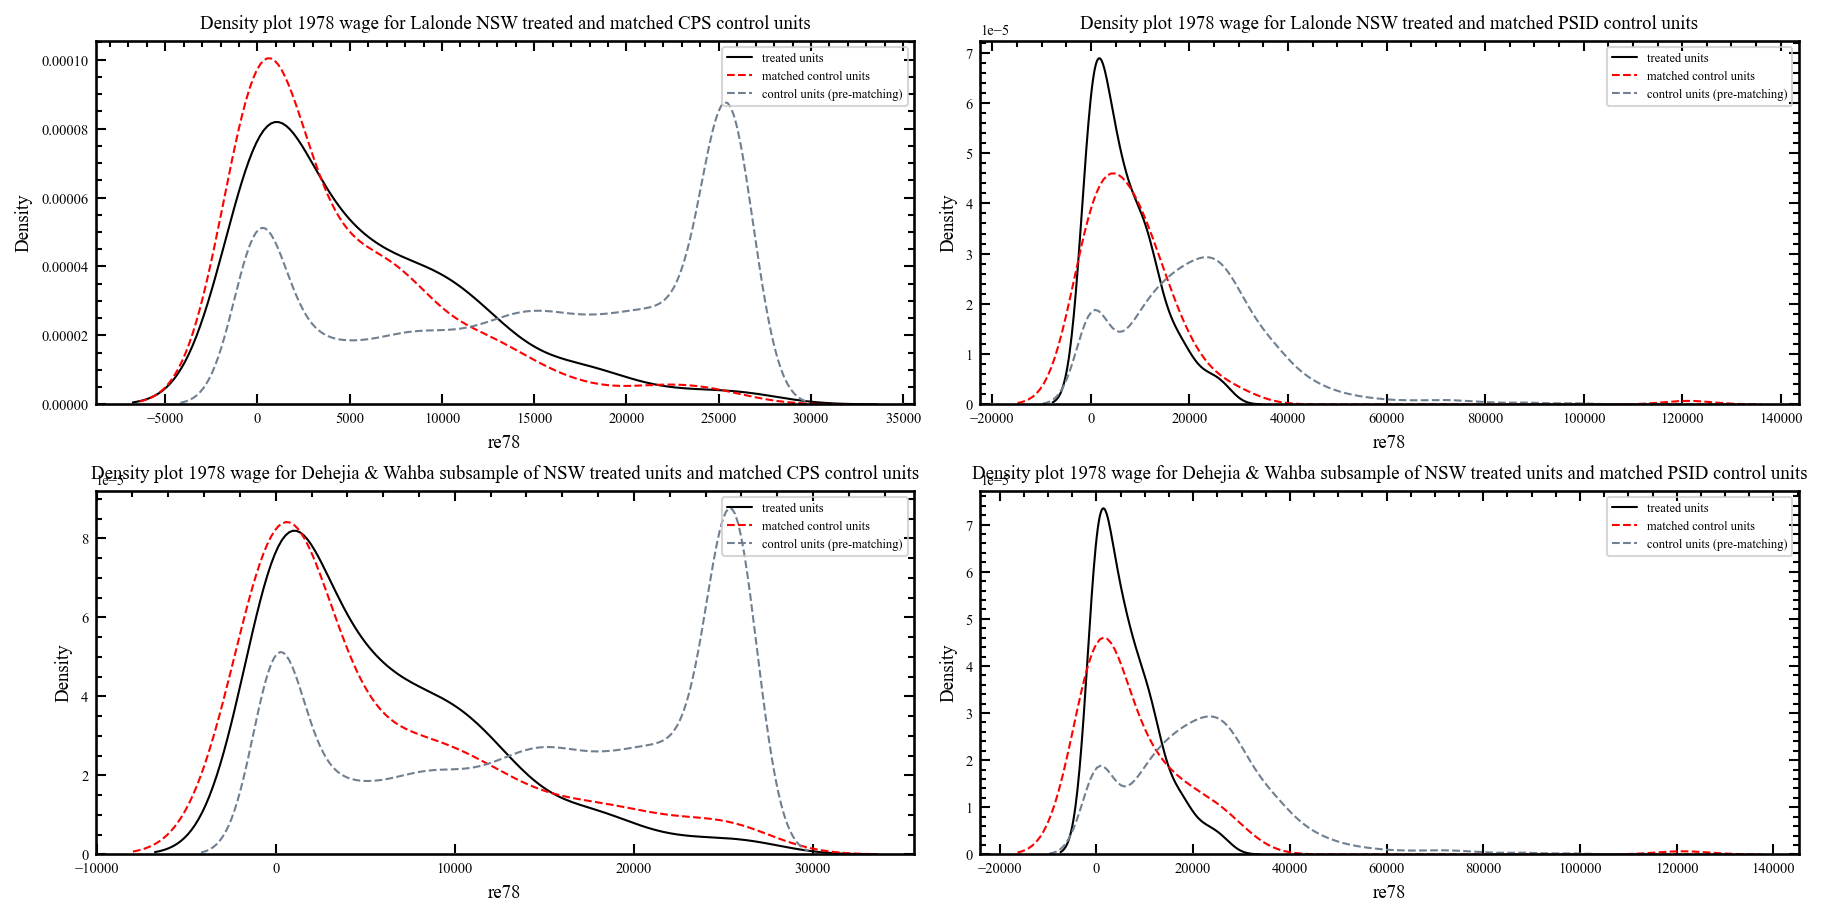

In [334]:
plot_matching_distributions(
                            nswCps_lalonde_LOGIT_psMatched,nswCps_lalonde_ps_LOGIT_withRe78,
                            nswPsid_lalonde_LOGIT_psMatched,nswPsid_lalonde_ps_LOGIT_withRe78,
                            nswCps_dehWab_LOGIT_psMatched,nswCps_dehWab_ps_LOGIT_withRe78,
                            nswPsid_dehWab_LOGIT_psMatched,nswPsid_dehWab_ps_LOGIT_withRe78,
                            )

# Density plot 1978 wage for Lalonde NSW treated and matched CPS control units using logistic regression
import matplotlib.ticker as tck

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,6))
# Global plot parameters
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ============ Lalonde sample ============ # 

# Density Lalonde NSW treated and matched CPS control
ax[0,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[0,0].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(quasi_nswTreated_matched_cpsControl_lalonde['re78'][quasi_nswTreated_matched_cpsControl_lalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,0])
sns.kdeplot(quasi_nswTreated_matched_cpsControl_lalonde['re78'][quasi_nswTreated_matched_cpsControl_lalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,0])
# Density plots pre-matching
sns.kdeplot(quasi_nswTreated_preMatched_cpsControl_lalonde['re78'][quasi_nswTreated_preMatched_cpsControl_lalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,0])
ax[0,0].set_title('Density plot 1978 wage for Lalonde NSW treated and matched CPS control units')
ax[0,0].legend(fontsize=6,loc = 1)

ax[0,0].yaxis.get_ticklocs(minor=True)
ax[0,0].minorticks_on()
ax[0,0].xaxis.set_tick_params(which='minor', bottom=False)
ax[0,0].xaxis.set_tick_params(which='major', bottom=False)

ax[0,0].tick_params(right='on',which='major',length= 5, width = 1)
ax[0,0].tick_params(right='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(left='on',which='major',length= 5, width = 1)
ax[0,0].tick_params(left='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(top='on',which='major',length=5, width = 1)
ax[0,0].tick_params(top='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[0,0].tick_params(bottom ='on',which='minor',length= 3, width = 1)


# Density Lalonde NSW treated and matched PSID control
ax[0,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[0,1].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(quasi_nswTreated_matched_psidControl_lalonde['re78'][quasi_nswTreated_matched_psidControl_lalonde['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,1])
sns.kdeplot(quasi_nswTreated_matched_psidControl_lalonde['re78'][quasi_nswTreated_matched_psidControl_lalonde['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,1])
# Density plots pre-matching
sns.kdeplot(quasi_nswTreated_preMatched_psidControl_lalonde['re78'][quasi_nswTreated_preMatched_psidControl_lalonde['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,1])
ax[0,1].set_title('Density plot 1978 wage for Lalonde NSW treated and matched PSID control units')
ax[0,1].legend(fontsize=6,loc = 1)

ax[0,1].yaxis.get_ticklocs(minor=True)
ax[0,1].minorticks_on()
ax[0,1].xaxis.set_tick_params(which='minor', bottom=False)
ax[0,1].xaxis.set_tick_params(which='major', bottom=False)

ax[0,1].tick_params(right='on',which='major',length= 5, width = 1)
ax[0,1].tick_params(right='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(left='on',which='major',length= 5, width = 1)
ax[0,1].tick_params(left='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(top='on',which='major',length=5, width = 1)
ax[0,1].tick_params(top='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[0,1].tick_params(bottom ='on',which='minor',length= 3, width = 1)

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
ax[1,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[1,0].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(quasi_nswTreated_matched_cpsControl_dehwab['re78'][quasi_nswTreated_matched_cpsControl_dehwab['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,0])
sns.kdeplot(quasi_nswTreated_matched_cpsControl_dehwab['re78'][quasi_nswTreated_matched_cpsControl_dehwab['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,0])
# Density plots pre-matching
sns.kdeplot(quasi_nswTreated_preMatched_cpsControl_dehwab['re78'][quasi_nswTreated_preMatched_cpsControl_dehwab['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,0])
ax[1,0].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched CPS control units')
ax[1,0].legend(fontsize=6,loc = 1)

ax[1,0].yaxis.get_ticklocs(minor=True)
ax[1,0].minorticks_on()
ax[1,0].xaxis.set_tick_params(which='minor', bottom=False)
ax[1,0].xaxis.set_tick_params(which='major', bottom=False)

ax[1,0].tick_params(right='on',which='major',length= 5, width = 1)
ax[1,0].tick_params(right='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(left='on',which='major',length= 5, width = 1)
ax[1,0].tick_params(left='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(top='on',which='major',length=5, width = 1)
ax[1,0].tick_params(top='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[1,0].tick_params(bottom ='on',which='minor',length= 3, width = 1)

# PSID 
ax[1,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[1,1].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(quasi_nswTreated_matched_psidControl_dehwab['re78'][quasi_nswTreated_matched_psidControl_dehwab['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,1])
sns.kdeplot(quasi_nswTreated_matched_psidControl_dehwab['re78'][quasi_nswTreated_matched_psidControl_dehwab['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,1])
# Density plots pre-matching
sns.kdeplot(quasi_nswTreated_preMatched_psidControl_dehwab['re78'][quasi_nswTreated_preMatched_psidControl_dehwab['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,1])
ax[1,1].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched PSID control units')
ax[1,1].legend(fontsize=6,loc = 1)

ax[1,1].yaxis.get_ticklocs(minor=True)
ax[1,1].minorticks_on()
ax[1,1].xaxis.set_tick_params(which='minor', bottom=False)
ax[1,1].xaxis.set_tick_params(which='major', bottom=False)

ax[1,1].tick_params(right='on',which='major',length= 5, width = 1)
ax[1,1].tick_params(right='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(left='on',which='major',length= 5, width = 1)
ax[1,1].tick_params(left='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(top='on',which='major',length=5, width = 1)
ax[1,1].tick_params(top='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(bottom ='off',which='major',length=5, width = 1)
#ax[1,1].tick_params(bottom ='off',which='minor',length= 3, width = 1)

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/logit_matching_density_plots.png', bbox_inches='tight')


<p> Estimate ATE </p>

### model (2) ; CART 

In [40]:
# import neccesary for CART 
from sklearn import tree           # for regression trees 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz                     # for plotting decision tree graphs

# read in data 
# experimental data 
nsw = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74 = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")

# non experimental data (cps)
cps1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv')
psid1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv')

del psid1['data_id']

# reset indexes
nsw_pd_df = nsw.reset_index(drop=True)
nswre74_pd_df = nswre74.reset_index(drop=True)
cps1 = cps1.reset_index(drop=True)
psid1 = psid1.reset_index(drop=True)

# ================================================ #

# Store outcome variable prior to feature scaling  

nsw_outcome = nsw[nsw_transformed_features['treat']==1].re78
nsw_re74_outcome = nswre74.re78
cps1_outcome = cps1.re78
psid1_outcome = psid1.re78


In [335]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [42]:
""" Select covariates for use in CART model """
sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Select covariates for modelling 
nsw_subset1 = ['treat','age','education','black','hispanic','married','nodegree','lnre75']
# Apply selection
nsw_lalonde = nsw[nsw_subset1]
cps_lalonde = cps1[nsw_subset1]
psid_lalonde = psid1[nsw_subset1]
# continuous  variables to be scaled 
lalonde_continuous_vars = ['age','education','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
nsw_lalonde[lalonde_continuous_vars] = sc.fit_transform(nsw_lalonde[lalonde_continuous_vars])
cps_lalonde[lalonde_continuous_vars] = sc.fit_transform(cps_lalonde[lalonde_continuous_vars])
psid_lalonde[lalonde_continuous_vars] = sc.fit_transform(psid_lalonde[lalonde_continuous_vars])

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Select covariates for modelling 
nswreDW_subset1 = ['treat','age','education','black','hispanic','married','nodegree','lnre74','lnre75']
# Apply selection
nsw_dw = nswre74_pd_df[nswreDW_subset1]
cps_dw = cps1[nswreDW_subset1]
psid1_dw = psid1[nswreDW_subset1]
# continuous  variables to be scaled 
nswDW_continuous_vars = ['age','education','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
nsw_dw[nswDW_continuous_vars] = sc.fit_transform(nsw_dw[nswDW_continuous_vars])
cps_dw[nswDW_continuous_vars] = sc.fit_transform(cps_dw[nswDW_continuous_vars])
psid1_dw[nswDW_continuous_vars] = sc.fit_transform(psid1_dw[nswDW_continuous_vars])

In [43]:
# Train test split 
# ======== Lalonde (1986) sub sample ======== #
nsw_lalonde = nsw_lalonde.sample(frac = 1,random_state=0) # Shuffle data 
# Define features and target 
FEATURES = nsw_lalonde.drop('treat', axis=1)
TARGET = nsw_lalonde.iloc[:,0]
# Train test split 
FEATURES_train, FEATURES_test, TARGET_train, TARGET_test = train_test_split(FEATURES, TARGET, test_size=0.3, random_state=42) 

# ======== Dehejia & Wahba (1999) sub sample ======== #
nsw_dw = nsw_dw.sample(frac = 1,random_state=0) # Shuffle data 
# Define features and target 
FEATURES_DW = nsw_dw.drop('treat', axis=1)
TARGET_DW = nsw_dw.iloc[:,0]
# Train test split 
FEATURES_DW_train, FEATURES_DW_test, TARGET_DW_train, TARGET_DW_test = train_test_split(FEATURES_DW, TARGET_DW, test_size=0.3, random_state=42) 

In [52]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]

grid_search_tree1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=5,scoring = 'roc_auc',)
grid_search_tree2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=5,scoring = 'roc_auc',)

In [53]:
grid_search_tree1.fit(FEATURES_train, TARGET_train)        # fit CART  - lalonde (1986) data
grid_search_tree2.fit(FEATURES_DW_train, TARGET_DW_train)  # fit CART  - dehejia & wahba (1999) subsample

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits
Fitting 5 folds for each of 6600 candidates, totalling 33000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                          'max_leaf_nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                             11, 12, 13, 14, 15, 16, 17, 18, 19,
                                             20, 21, 22, 23, 24, 25, 26, 27, 28,
                                             29, ...],
                          'min_samples_leaf': [2, 3, 4]}],
             scoring='roc_auc', verbose=1)

In [54]:
tree_predictions1 = grid_search_tree1.predict(FEATURES_test)    # predict CART   - lalonde (1986) data
tree_predictions2 = grid_search_tree2.predict(FEATURES_DW_test) # predict CART  - dehejia & wahba (1999) subsample

In [55]:
""" CART metrics """

# ======== Lalonde (1986) sample ======== #

print('--------------------- CART metrics ---------------------')
print('lalonde sample')

print(f'Accuracy : {metrics.accuracy_score(TARGET_test, tree_predictions1):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_test, tree_predictions1):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_test, tree_predictions1):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_test, tree_predictions1):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_test, tree_predictions1):.2f}')
print('____________________________________________________')

# ======== Dehejia & Wahba (1999) sub sample ======== #

print('dehejia & wahba sample')
print(f'Accuracy : {metrics.accuracy_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_DW_test, tree_predictions2):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_DW_test, tree_predictions2):.2f}')

print('____________________________________________________')

--------------------- CART metrics ---------------------
lalonde sample
Accuracy : 0.53
Precision : 0.37
Recall : 0.28
MSE : 0.47
f1 score : 0.32
____________________________________________________
dehejia & wahba sample
Accuracy : 0.57
Precision : 0.39
Recall : 0.26
MSE : 0.43
f1 score : 0.31
____________________________________________________


In [56]:
# Predict propensity scores on NSW , CPS and PSID 

# ============ Lalonde Subsample ============ # 

nsw_lalonde_ps_CARTmodel = propensity_score_funct(nsw_lalonde,grid_search_tree1)
nsw_lalonde_treated_ps_CARTmodel = nsw_lalonde_ps_CARTmodel[nsw_lalonde_ps_CARTmodel['treat'] == 1] # drop control units from lalonde dataset 

cps_lalonde_ps_CARTmodel = propensity_score_funct(cps_lalonde,grid_search_tree1)
psid_lalonde_ps_CARTmodel = propensity_score_funct(psid_lalonde,grid_search_tree1)

# Rejoin the outcome variable to dataframe with estimated propensity scores 
nsw_lalonde_treated_ps_CARTmodel_full = pd.merge(nsw_lalonde_treated_ps_CARTmodel, nsw_outcome, left_index=True, right_index=True)

cps_lalonde_ps_CARTmodel_full = pd.merge(cps_lalonde_ps_CARTmodel,cps1_outcome,left_index=True, right_index=True) # join cps data and outcome covariate for cps data
psid_lalonde_ps_CARTmodel_full = pd.merge(psid_lalonde_ps_CARTmodel,psid1_outcome,left_index=True, right_index=True) # join psid data and outcome covariate for psid data

# Combine treated units from lalonde sample with control units from comparions datasets 
quasi_data_nswCps_lalonde_ps = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,cps_lalonde_ps_CARTmodel_full],axis=0, ignore_index = True)
quasi_data_nswPsid_lalonde_ps = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,psid_lalonde_ps_CARTmodel_full],axis=0, ignore_index = True)

# ============ Dehejia & Wahba sub sample ============ # 

nsw_dw_ps_CARTmodel = propensity_score_funct(nsw_dw,grid_search_tree2)
nsw_treatedUnits_dw_ps_CARTmodel = nsw_dw_ps_CARTmodel[nsw_dw_ps_CARTmodel['treat'] == 1] # drop control units from lalonde dataset 

cps_dw_ps_CARTmodel = propensity_score_funct(cps_dw,grid_search_tree2)
psid_dw_ps_CARTmodel = propensity_score_funct(psid1_dw,grid_search_tree2)

# Rejoin the outcome variable to dataframe with estimated propensity scores 
nsw_dw_treatedUnits_ps_CARTmodel_full = pd.merge(nsw_dw_ps_CARTmodel, nsw_re74_outcome, left_index=True, right_index=True)
cps_dw_ps_CARTmodel_full = pd.merge(cps_dw_ps_CARTmodel,cps1_outcome,left_index=True, right_index=True)
psid_dw_ps_CARTmodel_full = pd.merge(psid_dw_ps_CARTmodel,psid1_outcome,left_index=True, right_index=True)

# Combine treated units with control units 
quasi_data_nswCps_dw_ps = pd.concat([nsw_dw_treatedUnits_ps_CARTmodel_full,cps_dw_ps_CARTmodel_full],axis=0, ignore_index = True)
quasi_data_nswPsid_dw_ps = pd.concat([nsw_dw_treatedUnits_ps_CARTmodel_full,psid_dw_ps_CARTmodel_full],axis=0, ignore_index = True)

In [57]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde Subsample ============ #  
caliper = np.std(quasi_data_nswCps_lalonde_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
nsw_lalonde_cps_ps_matched = psm.match(quasi_data_nswCps_lalonde_ps,'treat',['propensity_score'])
nsw_lalonde_cps_ps_pre_matched = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,cps_lalonde_ps_CARTmodel_full],axis=0,ignore_index=True)

caliper = np.std(quasi_data_nswPsid_lalonde_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and PSID comparison group 
nsw_lalonde_psid_ps_matched = psm.match(quasi_data_nswPsid_lalonde_ps,'treat',['propensity_score'])
nsw_lalonde_psid_ps_pre_matched = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,psid_lalonde_ps_CARTmodel_full],axis=0,ignore_index=True) # comparison before matchibg 

# ============ Dehejia & Wahba sub sample ============ # 

caliper = np.std(quasi_data_nswCps_dw_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
nsw_dw_cps_ps_matched = psm.match(quasi_data_nswCps_dw_ps,'treat',['propensity_score'])
nsw_dw_cps_ps_pre_matched = pd.concat([nsw_treatedUnits_dw_ps_CARTmodel,cps_dw_ps_CARTmodel_full],axis=0,ignore_index=True)


caliper = np.std(quasi_data_nswPsid_dw_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and PSID comparison group 
nsw_dw_psid_ps_matched = psm.match(quasi_data_nswPsid_dw_ps,'treat',['propensity_score'])
nsw_dw_psid_ps_pre_matched = pd.concat([nsw_treatedUnits_dw_ps_CARTmodel,psid_dw_ps_CARTmodel_full],axis=0,ignore_index=True) # comparison before matching

In [58]:
# SAVE Quasi experimental datasets with lalonde treated and matched controls 
nsw_lalonde_cps_ps_matched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedcpsComparison.csv',header = True,index = False)
nsw_lalonde_psid_ps_matched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedpsidComparison.csv',header = True,index = False)
nsw_dw_cps_ps_matched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedcpsComparison.csv',header = True,index = False)
nsw_dw_psid_ps_matched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedpsidComparison.csv',header = True,index = False)

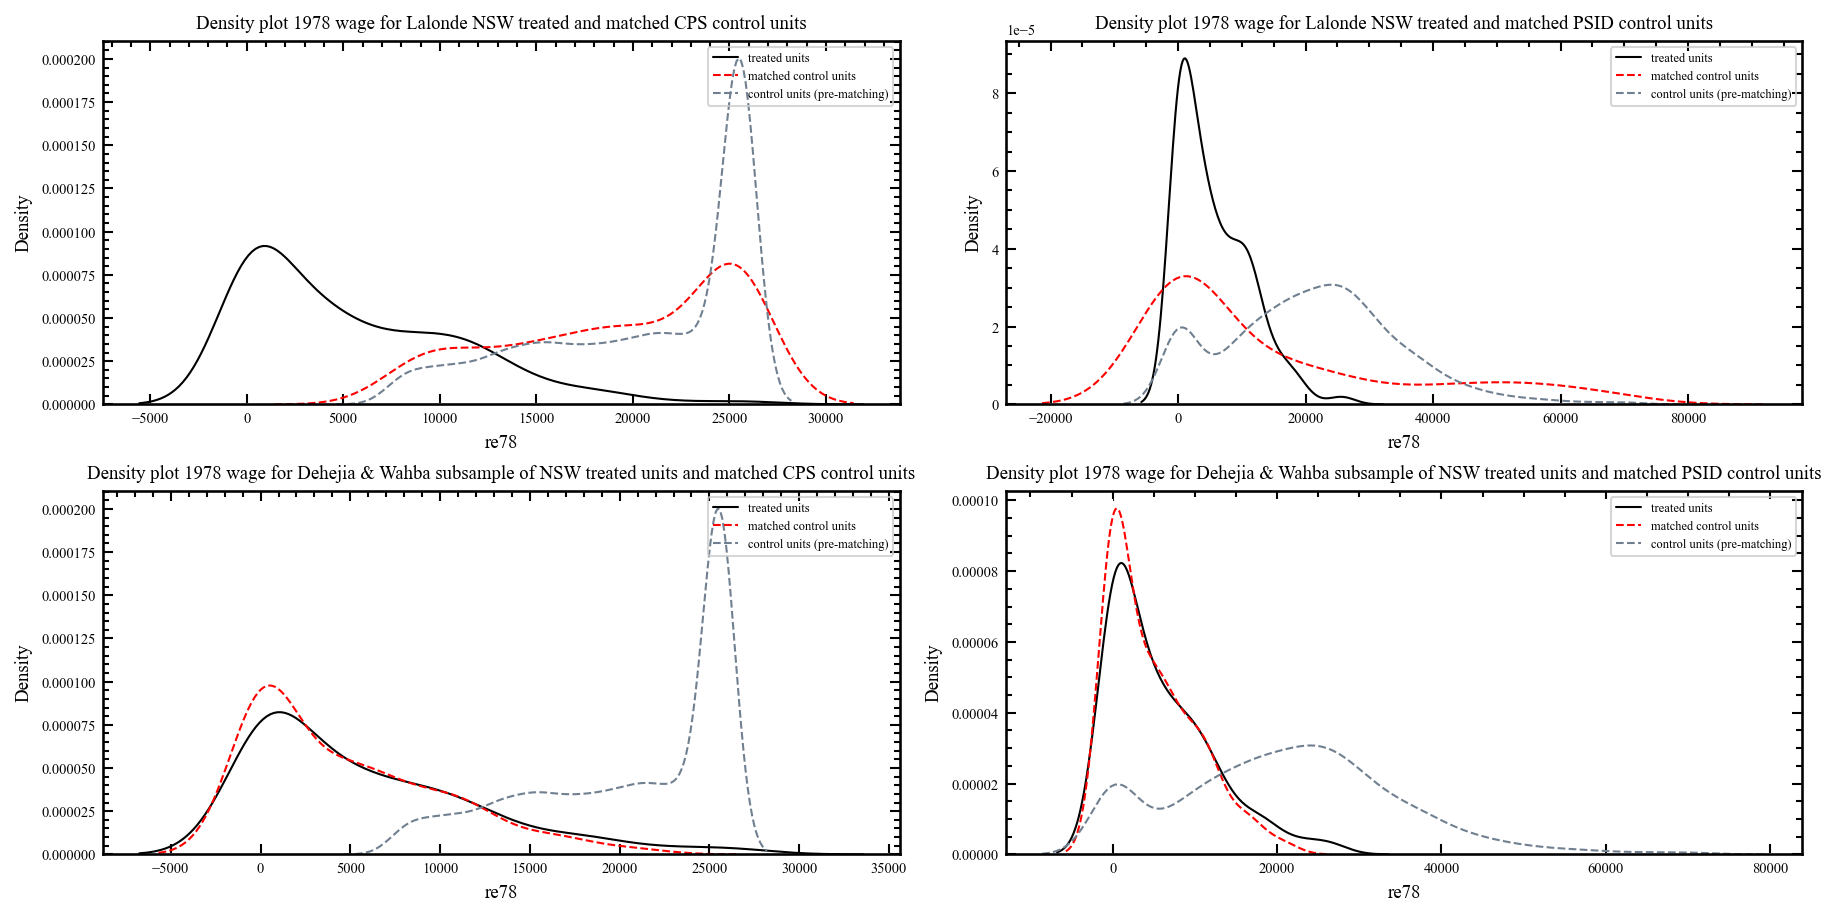

In [59]:
# Density plot 1978 wage for Lalonde NSW treated and matched CPS control units using logistic regression
import matplotlib.ticker as tck

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,6))

# Global plot parameters

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ============ Lalonde sample ============ # 

# Density Lalonde NSW treated and matched CPS control
ax[0,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[0,0].grid(color='white', axis='x')

# Density plots post-matching
sns.kdeplot(nsw_lalonde_cps_ps_matched['re78'][nsw_lalonde_cps_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,0])
sns.kdeplot(nsw_lalonde_cps_ps_matched['re78'][nsw_lalonde_cps_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,0])

# Density plots pre-matching
sns.kdeplot(nsw_lalonde_cps_ps_pre_matched['re78'][nsw_lalonde_cps_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,0])
ax[0,0].set_title('Density plot 1978 wage for Lalonde NSW treated and matched CPS control units')
ax[0,0].legend(fontsize=6,loc = 1)


ax[0,0].yaxis.get_ticklocs(minor=True)
ax[0,0].minorticks_on()
ax[0,0].xaxis.set_tick_params(which='minor', bottom=False)
ax[0,0].xaxis.set_tick_params(which='major', bottom=False)

ax[0,0].tick_params(right='on',which='major',length= 5, width = 1)
ax[0,0].tick_params(right='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(left='on',which='major',length= 5, width = 1)
ax[0,0].tick_params(left='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(top='on',which='major',length=5, width = 1)
ax[0,0].tick_params(top='on',which='minor',length= 3, width = 1)

ax[0,0].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[0,0].tick_params(bottom ='on',which='minor',length= 3, width = 1)


# Density Lalonde NSW treated and matched PSID control
ax[0,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[0,1].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(nsw_lalonde_psid_ps_matched['re78'][nsw_lalonde_psid_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[0,1])
sns.kdeplot(nsw_lalonde_psid_ps_matched['re78'][nsw_lalonde_psid_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[0,1])
# Density plots pre-matching
sns.kdeplot(nsw_lalonde_psid_ps_pre_matched['re78'][nsw_lalonde_psid_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[0,1])
ax[0,1].set_title('Density plot 1978 wage for Lalonde NSW treated and matched PSID control units')
ax[0,1].legend(fontsize=6,loc = 1)

ax[0,1].yaxis.get_ticklocs(minor=True)
ax[0,1].minorticks_on()
ax[0,1].xaxis.set_tick_params(which='minor', bottom=False)
ax[0,1].xaxis.set_tick_params(which='major', bottom=False)

ax[0,1].tick_params(right='on',which='major',length= 5, width = 1)
ax[0,1].tick_params(right='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(left='on',which='major',length= 5, width = 1)
ax[0,1].tick_params(left='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(top='on',which='major',length=5, width = 1)
ax[0,1].tick_params(top='on',which='minor',length= 3, width = 1)

ax[0,1].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[0,1].tick_params(bottom ='on',which='minor',length= 3, width = 1)

# ============ Dehejia & Wahba sub sample ============ # 
# CPS
ax[1,0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[1,0].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(nsw_dw_cps_ps_matched['re78'][nsw_dw_cps_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,0])
sns.kdeplot(nsw_dw_cps_ps_matched['re78'][nsw_dw_cps_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,0])
# Density plots pre-matching
sns.kdeplot(nsw_dw_cps_ps_pre_matched['re78'][nsw_dw_cps_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,0])
ax[1,0].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched CPS control units')
ax[1,0].legend(fontsize=6,loc = 1)

ax[1,0].yaxis.get_ticklocs(minor=True)
ax[1,0].minorticks_on()
ax[1,0].xaxis.set_tick_params(which='minor', bottom=False)
ax[1,0].xaxis.set_tick_params(which='major', bottom=False)

ax[1,0].tick_params(right='on',which='major',length= 5, width = 1)
ax[1,0].tick_params(right='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(left='on',which='major',length= 5, width = 1)
ax[1,0].tick_params(left='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(top='on',which='major',length=5, width = 1)
ax[1,0].tick_params(top='on',which='minor',length= 3, width = 1)

ax[1,0].tick_params(bottom ='on',which='major',length=5, width = 1)
#ax[1,0].tick_params(bottom ='on',which='minor',length= 3, width = 1)

# PSID 
ax[1,1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[1,1].grid(color='white', axis='x')
# Density plots post-matching
sns.kdeplot(nsw_dw_psid_ps_matched['re78'][nsw_dw_psid_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units', ax=ax[1,1])
sns.kdeplot(nsw_dw_psid_ps_matched['re78'][nsw_dw_psid_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units',ax=ax[1,1])
# Density plots pre-matching
sns.kdeplot(nsw_dw_psid_ps_pre_matched['re78'][nsw_dw_psid_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)',ax=ax[1,1])
ax[1,1].set_title('Density plot 1978 wage for Dehejia & Wahba subsample of NSW treated units and matched PSID control units')
ax[1,1].legend(fontsize=6,loc = 1)

ax[1,1].yaxis.get_ticklocs(minor=True)
ax[1,1].minorticks_on()
ax[1,1].xaxis.set_tick_params(which='minor', bottom=False)
ax[1,1].xaxis.set_tick_params(which='major', bottom=False)

ax[1,1].tick_params(right='on',which='major',length= 5, width = 1)
ax[1,1].tick_params(right='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(left='on',which='major',length= 5, width = 1)
ax[1,1].tick_params(left='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(top='on',which='major',length=5, width = 1)
ax[1,1].tick_params(top='on',which='minor',length= 3, width = 1)

ax[1,1].tick_params(bottom ='off',which='major',length=5, width = 1)
#ax[1,1].tick_params(bottom ='off',which='minor',length= 3, width = 1)

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/CART_matching_density_plots.png', bbox_inches='tight')


### model (3) ; Random Forest

### model (4) ; Boosted Trees

In [74]:
from xgboost import XGBClassifier
from xgboost import plot_tree

In [95]:
# Boosting parameters 
""""
Booster = type of model to run at each iteration
subsample = fraction of training samples (randomly selected) used to train each tree
colsample_bytree = fraction of features (randomly selected) used to train each tree

min_child_weight [default = 1] : Used to control over-fitting. 
                                Higher values prevent a model from learning 
                                relations which might be highly specific to the 
                                particular sample selected for a tree.

max_depth = max tree depth 
"""

params = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,3,4,5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
        'learning_rate': [0.01,0.025,0.05,0.075,0.1,0.2,0.3]
        }

params2 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.5, 0.7,0.8],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,None],
        'learning_rate': [0.01,0.025,0.05]
        }        

# Set up tree classifier
estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42,
    nthread=4
)       

# Set up grid search 
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'roc_auc',
    cv = 5,
    verbose= True
)

In [96]:
# Fit models
# ======== Lalonde (1986) sample ======== #
model1 = grid_search.fit(FEATURES_train,TARGET_train)
y_pred= model1.predict(FEATURES_test)
# ======== Dehejia & Wahba (1999) sub sample ======== #
model2 =grid_search.fit(FEATURES_DW_train,TARGET_DW_train)
y_pred_dw = model2.predict(FEATURES_DW_test)

Fitting 5 folds for each of 61600 candidates, totalling 308000 fits


KeyboardInterrupt: 

In [97]:
#y_pred= model1.predict(FEATURES_test)
y_pred = grid_search.predict(FEATURES_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [71]:
""" XGboost metrics """

# ======== Lalonde (1986) sample ======== #

print('--------------------- XGBoost metrics ---------------------')
print('lalonde sample')

print(f'Accuracy : {metrics.accuracy_score(TARGET_test, y_pred):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_test, y_pred):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_test, y_pred):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_test, y_pred):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_test, y_pred):.2f}')
print('____________________________________________________')

# ======== Dehejia & Wahba (1999) sub sample ======== #

#print('dehejia & wahba sample')
#print(f'Accuracy : {metrics.accuracy_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'Precision : {metrics.precision_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'Recall : {metrics.recall_score(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'MSE : {metrics.mean_squared_error(TARGET_DW_test, tree_predictions2):.2f}')
#print(f'f1 score : {metrics.f1_score(TARGET_DW_test, tree_predictions2):.2f}')

print('____________________________________________________')

--------------------- XGBoost metrics ---------------------
lalonde sample
Accuracy : 0.57
Precision : 0.27
Recall : 0.05
MSE : 0.43
f1 score : 0.09
____________________________________________________
____________________________________________________


### model (5) - artifical neural network

#### define ANN class 

In [46]:
class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<p> test distributions</p>

<p> plot distribtions of key variables pre and post matching </p>

(-10000.0, 45000.0)

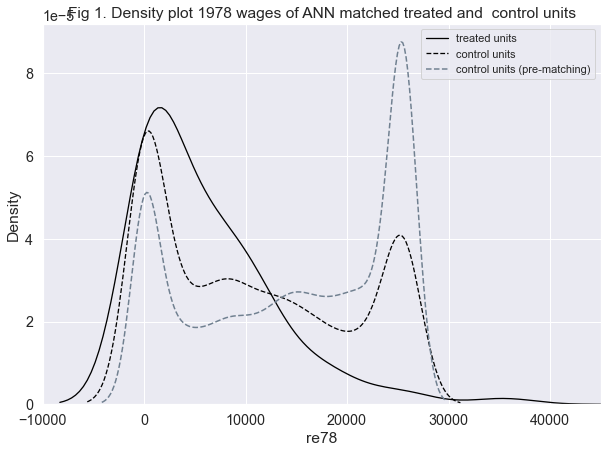

In [50]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['re78'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['re78'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
plt.title('Fig 1. Density plot 1978 wages of ANN matched treated and  control units')
# Density plots pre-matching
sns.kdeplot(before_matched_df['re78'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.legend(fontsize=11,loc = 1)
plt.xlim([-10000, 45000])



(2.0, 21.0)

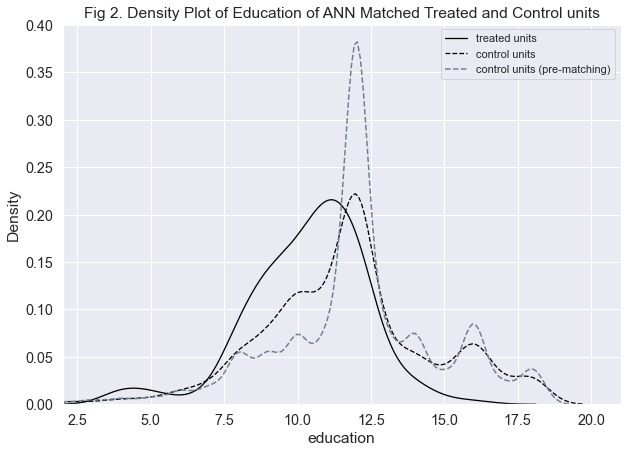

In [51]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['education'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['education'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
sns.kdeplot(before_matched_df['education'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')
plt.title('Fig 2. Density Plot of Education of ANN Matched Treated and Control units')
plt.legend(fontsize=11,loc = 1)
plt.xlim([2, 21])

# Matching Anlysis

In [118]:
# Load quasi datasets 

# Logit 

logitNswCps_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedCpsComparison.csv')
logitNswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_Lalonde_MatchedPsidComparison.csv')
logitNswCps_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedCpsComparison.csv')
logitNswPsid_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/LOGIT_quasi_experimental_data_nswTreated_DehWab_MatchedPsidComparison.csv')

# Cart 

cartNswCps_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedcpsComparison.csv')
cartNswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_Lalonde_MatchedpsidComparison.csv')
cartNswCps_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedcpsComparison.csv')
cartNswPsid_dehwab = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/CART_quasi_experimental_data_nswTreated_DehWab_MatchedpsidComparison.csv')


# Forest 

# XGBoosted tree  

# ANN tree model 

min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q5 0.3047619047619048


In [127]:
print('treated')
print('min',np.min(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('max',np.max(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('median',np.median(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]))
print('Q1',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1], 25)) 
print('Q3',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1], 75)) 
print('control')
print('min',np.min(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('max',np.max(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('median',np.median(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]))
print('Q1',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0], 25)) 
print('Q3',np.percentile(logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0], 75)) 

treated
min 0.3458259121357014
max 0.601949267164903
median 0.4499112381214718
Q1 0.4184566696975808
Q3 0.48683804987340856
control
min 0.3462317153588036
max 0.601953759453305
median 0.44995011037502364
Q1 0.41855193399124035
Q3 0.48682041011957167


In [126]:
print('treated')
print('min',np.min(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('max',np.max(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('median',np.median(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1]))
print('Q1',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1], 25)) 
print('Q3',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==1], 75)) 
print('control')
print('min',np.min(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('max',np.max(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('median',np.median(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]))
print('Q1',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0], 25)) 
print('Q3',np.percentile(cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0], 75)) 

treated
min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q3 0.6666666666666666
control
min 0.1428571428571428
max 0.75
median 0.3047619047619048
Q1 0.3047619047619048
Q3 0.6666666666666666


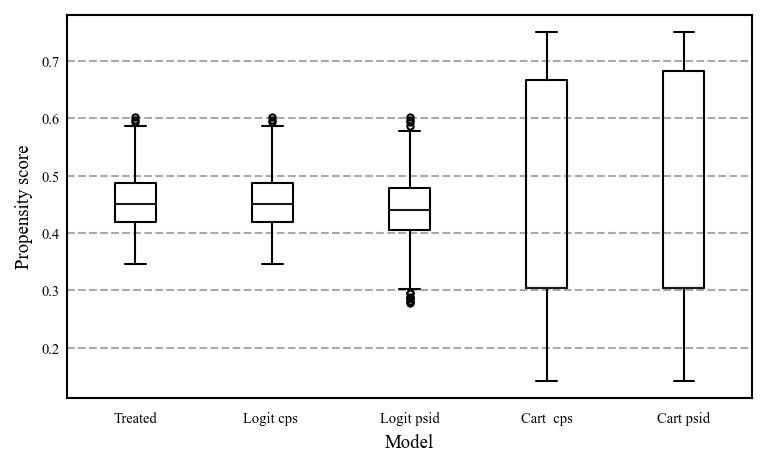

In [120]:
# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()